In [29]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import stats
from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M')
import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits import mplot3d
from sklearn import preprocessing, svm 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 

In [30]:
df = pd.read_csv('./inv2_emi_data_t345678.csv',
                encoding="utf-8-sig",
                header=0,
                infer_datetime_format=True,
                parse_dates={'datetime':[5]},
                index_col=['datetime']
                )

In [31]:
df['time'] = df.index
df.loc[:,'year'] = pd.Series(df.index.year, df.index)
df.loc[:,'month'] = pd.Series(df.index.month, df.index)
df.loc[:,'day'] = pd.Series(df.index.day, df.index)
df.loc[:,'hour'] = pd.Series(df.index.hour, df.index)
df.loc[:,'dayofweek'] = pd.Series(df.index.dayofweek, df.index)
df.loc[:,'dayname'] = pd.Series(df.index.day_name(), df.index)
df.loc[:,'hourofweek'] = pd.Series((df.hour+24*df.dayofweek), df.index)
df.loc[:,'hourofmonth'] = pd.Series((df.hour+24*(df.day-1)), df.index)
df.loc[:,'Tcell']=pd.Series((df['Ambient temperature(℃)']+df['Irradiance(W/㎡)']/800*(25-20)), df.index)
df.loc[:,'Pm']=pd.Series((2.172*1.303*220*2*590*df['Irradiance(W/㎡)']/1000*(1+0.0045*(df['Tcell']-25))*20.5/100), df.index)
df.loc[:,'Hieu suat']=pd.Series((df['Total input power(kW)']*1000/df['Pm']*100), df.index)
df.loc[:,'date'] = pd.Series(df.index.date, df.index)
df=df[df['Ambient temperature(℃)']>6]
df=df[df['Irradiance(W/㎡)']>300]
df=df[df['Total input power(kW)']>76]
df=df[df['Hieu suat']>55]
df.head(10)

,Unnamed: 0.1,Unnamed: 0,Site Name,Management Domain,ManageObject_x,Ambient temperature(℃),PV Temperature(℃),Wind speed(m/s),Wind direction(°),Daily irradiation(MJ/㎡),...,day,hour,dayofweek,dayname,hourofweek,hourofmonth,Tcell,Pm,Hieu suat,date
datetime,,,,,,,,,,,,,,,,,,,,,
2022-03-04 10:15:00,103,103,VNM - Đà Nẵng - Nhà Máy,/BCG Energy,1020C0058922/EM001020C0058922,30.6,38.8,1.7,NaN,3.870,...,4,10,4,Friday,106,82,33.537500,73507.755992,118.773861,2022-03-04
2022-03-04 10:20:00,104,104,VNM - Đà Nẵng - Nhà Máy,/BCG Energy,1020C0058922/EM001020C0058922,29.4,41.2,1.4,NaN,4.039,...,4,10,4,Friday,106,82,33.389375,99765.707730,89.783355,2022-03-04
2022-03-04 10:25:00,105,105,VNM - Đà Nẵng - Nhà Máy,/BCG Energy,1020C0058922/EM001020C0058922,29.3,42.0,2.4,NaN,4.252,...,4,10,4,Friday,106,82,34.078750,119863.526665,76.805683,2022-03-04
2022-03-04 10:30:00,106,106,VNM - Đà Nẵng - Nhà Máy,/BCG Energy,1020C0058922/EM001020C0058922,29.3,42.9,4.5,NaN,4.197,...,4,10,4,Friday,106,82,34.449375,129366.728410,72.081130,2022-03-04
2022-03-04 10:35:00,107,107,VNM - Đà Nẵng - Nhà Máy,/BCG Energy,1020C0058922/EM001020C0058922,29.7,44.7,0.8,NaN,4.444,...,4,10,4,Friday,106,82,34.868125,130072.464747,71.713871,2022-03-04
2022-03-04 10:40:00,108,108,VNM - Đà Nẵng - Nhà Máy,/BCG Energy,1020C0058922/EM001020C0058922,29.7,45.6,2.0,NaN,4.692,...,4,10,4,Friday,106,82,34.773750,127645.289181,72.532250,2022-03-04
2022-03-04 10:45:00,109,109,VNM - Đà Nẵng - Nhà Máy,/BCG Energy,1020C0058922/EM001020C0058922,30.6,46.5,3.0,NaN,4.942,...,4,10,4,Friday,106,82,35.882500,133532.155492,71.483906,2022-03-04
2022-03-04 10:50:00,110,110,VNM - Đà Nẵng - Nhà Máy,/BCG Energy,1020C0058922/EM001020C0058922,31.3,47.2,2.2,NaN,5.194,...,4,10,4,Friday,106,82,36.598125,134338.280105,71.443523,2022-03-04
2022-03-04 10:55:00,111,111,VNM - Đà Nẵng - Nhà Máy,/BCG Energy,1020C0058922/EM001020C0058922,30.7,47.5,1.5,NaN,5.447,...,4,10,4,Friday,106,82,36.038750,135044.514571,70.368649,2022-03-04


In [32]:
df1=df.groupby(['month','date','hour'])['Total input power(kW)','Ambient temperature(℃)','Irradiance(W/㎡)'].mean()
df1=df1.reset_index()
df1=df1[df1.groupby(['month','date'])['Irradiance(W/㎡)'].transform(max)==df1['Irradiance(W/㎡)']]
df1=df1.reset_index()
df1.loc[:,'Tcell']=pd.Series((df1['Ambient temperature(℃)']+df1['Irradiance(W/㎡)']/800*(25-20)), df1.index)
df1.loc[:,'Pm']=pd.Series((2.172*1.303*220*2*590*df1['Irradiance(W/㎡)']/1000*(1+0.0045*(df1['Tcell']-25))*20.5/100), df1.index)
df1.loc[:,'Hieu suat']=pd.Series((df1['Total input power(kW)']*1000/df1['Pm']*100), df1.index)
df1=df1[df1['Hieu suat']<80]
print(df1)
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df1['date'],
    y=df1['Total input power(kW)'],
    name="Sản lượng điện trung bình cao nhất theo khung giờ mỗi ngày inverter 2 "))
fig.add_trace(go.Scatter(
    x=df1['date'],
    y=df1['Hieu suat'],
    name="Hiệu suất trung bình cao nhất theo khung giờ mỗi ngày inverter 2 "))
fig . update_traces (
    showlegend = True 
    )
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()

     index  month        date  hour  Total input power(kW)  \
0        1      3  2022-03-04    11              93.223000   
1        2      3  2022-03-19    12              83.183000   
2        4      3  2022-03-21    10              80.392000   
3        7      3  2022-03-22    11              97.147333   
4       14      3  2022-03-23    12              98.646909   
..     ...    ...         ...   ...                    ...   
138    766      8  2022-08-21    11              99.580000   
139    772      8  2022-08-22    12              97.807667   
140    777      8  2022-08-23    11              96.888000   
141    784      8  2022-08-24    13              93.344250   
142    787      8  2022-08-25     9              76.128000   

     Ambient temperature(℃)  Irradiance(W/㎡)      Tcell             Pm  \
0                 23.300000       842.800000  28.567500  128974.542439   
1                  7.100000       852.550000  12.428437  121141.066196   
2                  8.166667      

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8284\58016977.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [33]:
df1['stt']=df1.index
df_binary = df1[['stt', 'Hieu suat']] 
  
# Taking only the selected two attributes from the dataset 
df_binary.columns = ['stt', 'Hieu suat'] 
  
# Renaming the columns for easier writing of the code 
df_binary.head() 
  
# Displaying only the 1st  rows along with the column names 

,stt,Hieu suat
0,0,72.280156
1,1,68.666227
2,2,78.893108
3,3,66.338579
4,4,66.252786


-0.16886573258058557


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8284\3909986184.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8284\3909986184.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



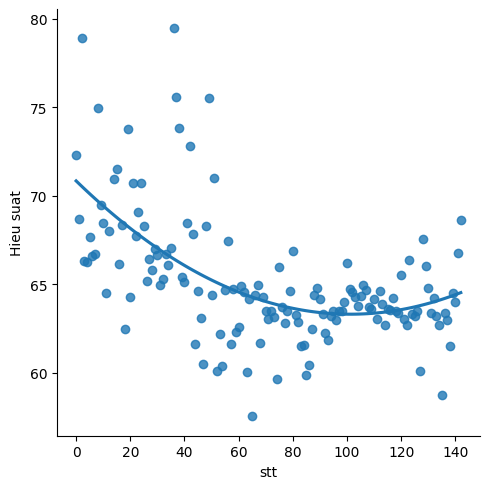

In [34]:
sns.lmplot(x ="stt", y ="Hieu suat", data = df_binary, order = 2, ci = None)
# Eliminating NaN or missing input numbers 
df_binary.fillna(method ='ffill', inplace = True)
X = np.array(df_binary['stt']).reshape(-1, 1) 
y = np.array(df_binary['Hieu suat']).reshape(-1, 1) 
  
# Separating the data into independent and dependent variables 
# Converting each dataframe into a numpy array  
# since each dataframe contains only one column 
df_binary.dropna(inplace = True) 
  
# Dropping any rows with Nan values 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 
  
# Splitting the data into training and testing data 
regr = LinearRegression() 
  
regr.fit(X_train, y_train) 
print(regr.score(X_test, y_test))

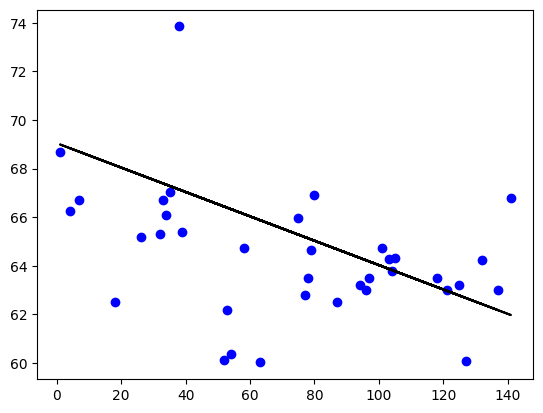

In [35]:
y_pred = regr.predict(X_test) 
plt.scatter(X_test, y_test, color ='b') 
plt.plot(X_test, y_pred, color ='k') 
plt.show() 

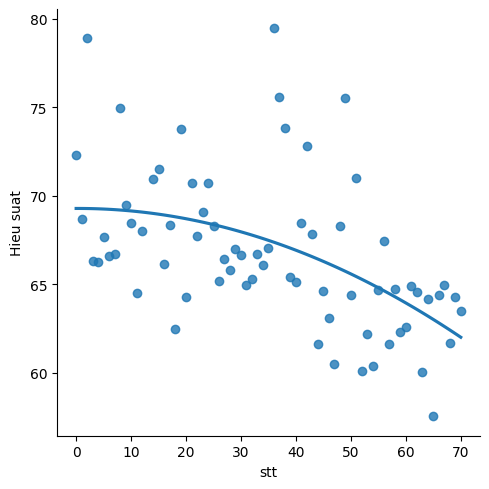

In [36]:
df_binary1 = df_binary[:][:70]
  
# Selecting the 1st 500 rows of the data 
sns.lmplot(x ="stt", y ="Hieu suat", data = df_binary1, 
                               order = 2, ci = None)

In [37]:
df_binary1.fillna(method ='ffill', inplace = True) 
  
X = np.array(df_binary1['stt']).reshape(-1, 1) 
y = np.array(df_binary1['Hieu suat']).reshape(-1, 1) 
  
df_binary1.dropna(inplace = True) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 
  
regr = LinearRegression() 
regr.fit(X_train, y_train) 
print(regr.score(X_test, y_test))

-0.060843468143774615


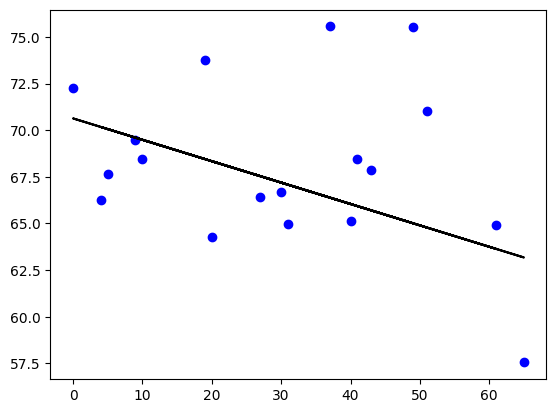

In [38]:
y_pred = regr.predict(X_test) 
plt.scatter(X_test, y_test, color ='b') 
plt.plot(X_test, y_pred, color ='k') 
  
plt.show() 

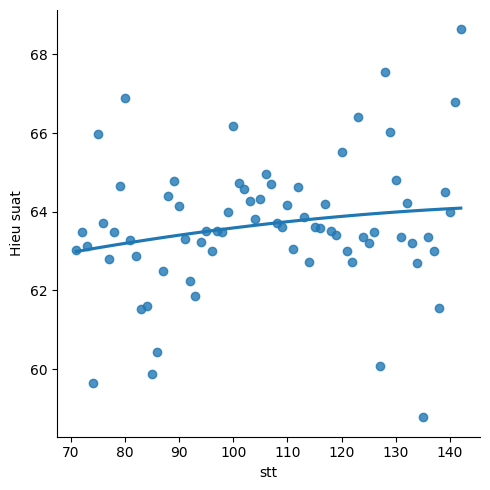

In [39]:
df_binary2 = df_binary[:][70:142]
  
# Selecting the 1st 500 rows of the data 
sns.lmplot(x ="stt", y ="Hieu suat", data = df_binary2, 
                               order = 2, ci = None)

In [40]:
df_binary2.fillna(method ='ffill', inplace = True) 
  
X = np.array(df_binary2['stt']).reshape(-1, 1) 
y = np.array(df_binary2['Hieu suat']).reshape(-1, 1) 
  
df_binary2.dropna(inplace = True) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 
  
regr = LinearRegression() 
regr.fit(X_train, y_train) 
print(regr.score(X_test, y_test))

-0.6798749089092091


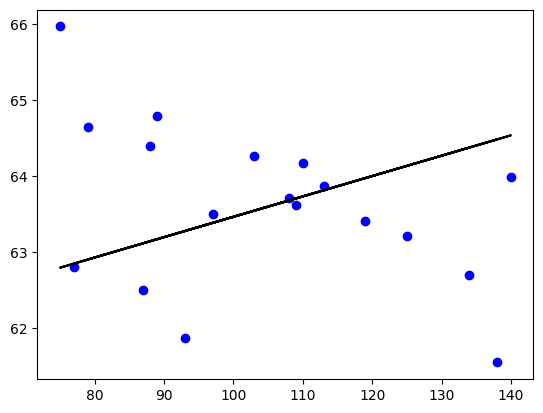

In [41]:
y_pred = regr.predict(X_test) 
plt.scatter(X_test, y_test, color ='b') 
plt.plot(X_test, y_pred, color ='k') 
  
plt.show() 

    index  month        date  hour  Total input power(kW)  \
0       1      3  2022-03-04    11              93.223000   
1       2      3  2022-03-19    12              83.183000   
2       4      3  2022-03-21    10              80.392000   
3       7      3  2022-03-22    11              97.147333   
4      14      3  2022-03-23    12              98.646909   
5      19      3  2022-03-24    12              99.364200   
6      24      3  2022-03-25    11             100.577273   
7      30      3  2022-03-26    11              96.561083   
8      34      3  2022-03-28    10              97.070000   
9      40      3  2022-03-29    10             102.428500   
10     45      3  2022-03-30    10             107.083000   

    Ambient temperature(℃)  Irradiance(W/㎡)      Tcell             Pm  \
0                23.300000       842.800000  28.567500  128974.542439   
1                 7.100000       852.550000  12.428437  121141.066196   
2                 8.166667       716.400000  12.

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8284\1201663089.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8284\1201663089.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8284\1201663089.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



-0.07764238414385516


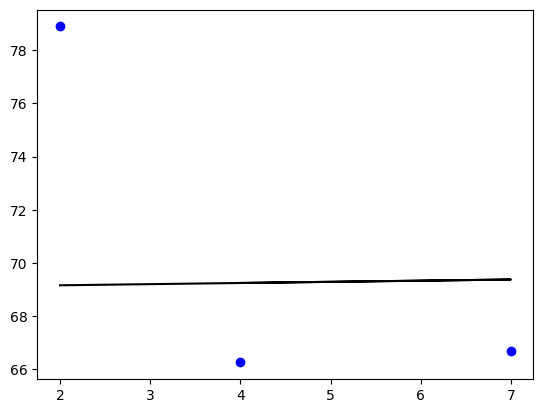

    index  month        date  hour  Total input power(kW)  \
11     53      4  2022-04-03    13             107.548667   
12     54      4  2022-04-04    12              80.466500   
13     56      4  2022-04-05    15              83.129000   
14     58      4  2022-04-06    12              94.991500   
15     65      4  2022-04-07    12             100.646800   
16     70      4  2022-04-08    11              95.573818   
17     76      4  2022-04-09    11             101.279000   
18     81      4  2022-04-10    12              85.350400   
19     84      4  2022-04-11     9              79.727250   
20     90      4  2022-04-12    12              79.184500   
21     93      4  2022-04-13    11              87.941444   
22     98      4  2022-04-14    11              91.196900   
23    103      4  2022-04-15    11              93.454667   
24    107      4  2022-04-16    11              91.289625   
25    114      4  2022-04-17    11              97.654714   
26    121      4  2022-0

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8284\1201663089.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



-0.8845794187455085


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8284\1201663089.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8284\1201663089.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



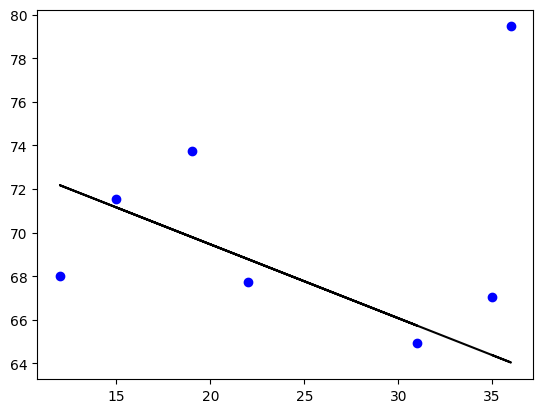

    index  month        date  hour  Total input power(kW)  \
37    177      5  2022-05-01    10              91.706000   
38    178      5  2022-05-02    11              80.656667   
39    180      5  2022-05-05    10              94.794455   
40    187      5  2022-05-06    11             101.394818   
41    193      5  2022-05-07    10             100.581750   
42    198      5  2022-05-08    11              83.956500   
43    200      5  2022-05-09    13              97.476444   
44    205      5  2022-05-10    11             103.900400   
45    211      5  2022-05-11    12              97.696375   
46    217      5  2022-05-12    11             100.139800   
47    223      5  2022-05-13    12              96.400500   
48    231      5  2022-05-14    12              95.655667   
49    234      5  2022-05-15     8              81.856000   
50    237      5  2022-05-16    10              96.314000   
51    244      5  2022-05-17    11              95.747333   
52    247      5  2022-0

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8284\1201663089.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8284\1201663089.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8284\1201663089.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.5504348183916059


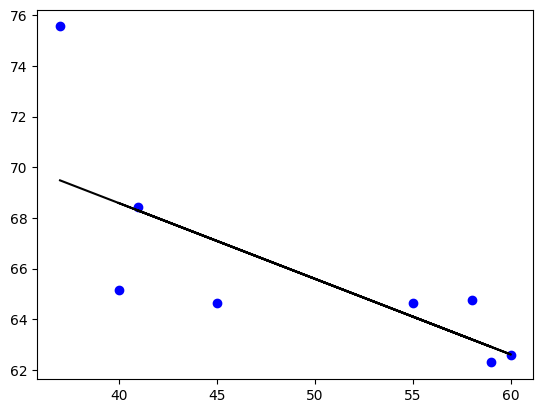

    index  month        date  hour  Total input power(kW)  \
66    331      6  2022-06-01    11              98.067333   
67    338      6  2022-06-02    11              95.853083   
68    345      6  2022-06-03    11              94.078167   
69    352      6  2022-06-04    11             100.047417   
70    361      6  2022-06-05    12              96.202000   
71    366      6  2022-06-06    11              94.759583   
72    372      6  2022-06-07    11              99.352417   
73    379      6  2022-06-08    12              94.901333   
74    386      6  2022-06-09    12              97.464250   
75    391      6  2022-06-10    11              83.133818   
76    395      6  2022-06-11    11              88.787000   
77    401      6  2022-06-12    11              96.632400   
78    407      6  2022-06-13    11              97.014583   
79    412      6  2022-06-14    10              89.753571   
80    418      6  2022-06-15    11              88.192400   
81    424      6  2022-0

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8284\1201663089.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8284\1201663089.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8284\1201663089.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



-0.026585536896934325


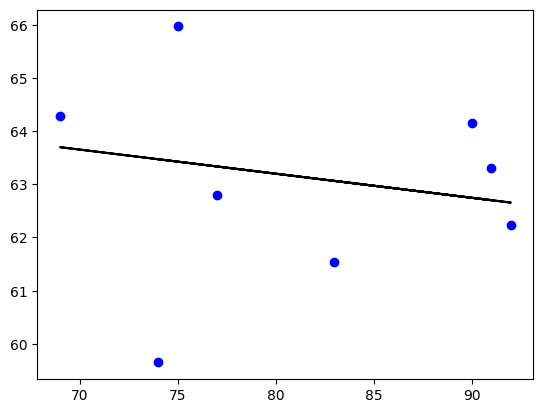

     index  month        date  hour  Total input power(kW)  \
95     509      7  2022-07-03    11              90.805636   
96     514      7  2022-07-04    11              94.068125   
97     519      7  2022-07-05    11              99.076364   
98     525      7  2022-07-06    11              93.660667   
99     530      7  2022-07-07    10              93.915545   
100    534      7  2022-07-08    10              89.258556   
101    539      7  2022-07-09    10              94.294800   
102    545      7  2022-07-11    12             101.456857   
103    551      7  2022-07-12    11             100.157833   
104    559      7  2022-07-13    12             100.047083   
105    566      7  2022-07-14    11              98.911333   
106    573      7  2022-07-15    11              99.353750   
107    579      7  2022-07-16    11              96.638833   
108    585      7  2022-07-17    11              95.846917   
109    591      7  2022-07-18    11              97.758083   
110    5

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8284\1201663089.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8284\1201663089.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8284\1201663089.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



-0.9431911336295615


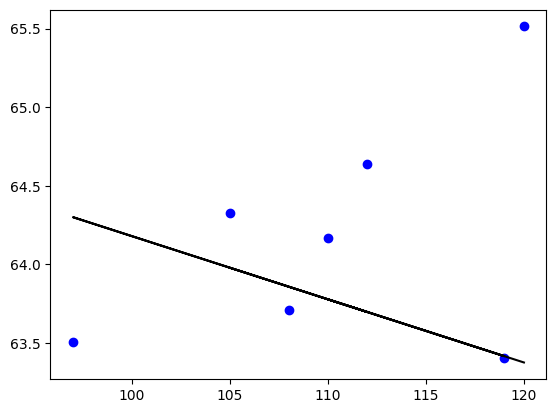

     index  month        date  hour  Total input power(kW)  \
123    681      8  2022-08-01    11              92.484909   
124    688      8  2022-08-02    11              99.305750   
125    694      8  2022-08-03    11             107.324000   
126    701      8  2022-08-04    11              98.773667   
127    709      8  2022-08-05    12              96.311500   
128    711      8  2022-08-06    11              82.147429   
129    712      8  2022-08-10     9              85.887333   
130    716      8  2022-08-12    12              89.481900   
131    721      8  2022-08-13    11              98.821500   
132    728      8  2022-08-14    11              98.700417   
133    734      8  2022-08-15    11             101.140000   
134    741      8  2022-08-16    11              98.687727   
135    748      8  2022-08-17    11              93.640333   
136    755      8  2022-08-18    12              98.449333   
137    762      8  2022-08-19    12              97.675556   
138    7

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8284\1201663089.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8284\1201663089.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8284\1201663089.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



-0.48184107475228966


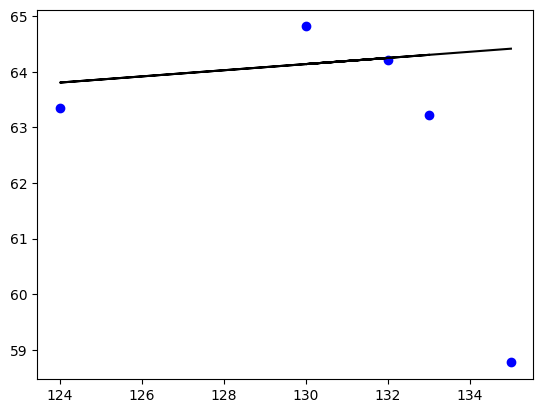

In [42]:
i=3
while i<=8:
    c=str(i)
    df1=df.groupby(['month','date','hour'])['Total input power(kW)','Ambient temperature(℃)','Irradiance(W/㎡)'].mean()
    df1=df1.reset_index()
    df1=df1[df1.groupby(['month','date'])['Irradiance(W/㎡)'].transform(max)==df1['Irradiance(W/㎡)']]
    df1=df1.reset_index()
    df1.loc[:,'Tcell']=pd.Series((df1['Ambient temperature(℃)']+df1['Irradiance(W/㎡)']/800*(25-20)), df1.index)
    df1.loc[:,'Pm']=pd.Series((2.172*1.303*220*2*590*df1['Irradiance(W/㎡)']/1000*(1+0.0045*(df1['Tcell']-25))*20.5/100), df1.index)
    df1.loc[:,'Hieu suat']=pd.Series((df1['Total input power(kW)']*1000/df1['Pm']*100), df1.index)
    df1=df1[df1['Hieu suat']<100]
    df1=df1[df1['month']==i]
    print(df1)
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df1['date'],
        y=df1['Total input power(kW)'],
        name="Sản lượng điện trung bình cao nhất theo khung giờ mỗi ngày inverter 3 tháng "+c))
    fig.add_trace(go.Scatter(
        x=df1['date'],
        y=df1['Hieu suat'],
        name="Hiệu suất trung bình cao nhất theo khung giờ mỗi ngày inverter 3 tháng "+c))
    fig . update_traces (
        showlegend = True 
        )
    fig.update_xaxes(
        rangeslider_visible=True,
    )
    fig.show()
    df1['stt']=df1.index
    df_binary = df1[['stt', 'Hieu suat']] 
    
    # Taking only the selected two attributes from the dataset 
    df_binary.columns = ['stt', 'Hieu suat'] 
    
    # Renaming the columns for easier writing of the code 
    df_binary.head() 
    
    # Displaying only the 1st  rows along with the column names 
    # Eliminating NaN or missing input numbers 
    df_binary.fillna(method ='ffill', inplace = True)
    X = np.array(df_binary['stt']).reshape(-1, 1) 
    y = np.array(df_binary['Hieu suat']).reshape(-1, 1) 
    
    # Separating the data into independent and dependent variables 
    # Converting each dataframe into a numpy array  
    # since each dataframe contains only one column 
    df_binary.dropna(inplace = True) 
    
    # Dropping any rows with Nan values 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 
    
    # Splitting the data into training and testing data 
    regr = LinearRegression() 
    
    regr.fit(X_train, y_train) 
    print(regr.score(X_test, y_test))
    y_pred = regr.predict(X_test) 
    plt.scatter(X_test, y_test, color ='b') 
    plt.plot(X_test, y_pred, color ='k') 
    
    plt.show() 
    i=i+1